## RBC Model With Different Prior Term TFP Coefficients

In this experiment we model the different impulse responses for output, labor, and consumption for differing coefficients on the prior term's total factor productivity.

Recall that in Prescott's Real Business Cycle model, the model posits that the main driver of the fluctuation of macroeconomic quantities over the Real Business Cycle is due to the total factor productivity, the solow residual in the Cobb-Douglas Production function. The idea would be that certain technological changes and institution changes and other things drive these fluctuations.

Here, we look to see how impulse responses in response to a 1% shock to TFP changes based on differing parameter values for $\rho$, which is our coefficient on the prior term's TFP value in the present time frame. Our modeling of TFP's evolution over time utilizes an AR model, an autoregressive model, where the $logTFP_{t+1} = \rhologTFP_{t}+\epsilon_{t}$. How do the impulse response changes when the shock to TFP indicates that it will last longer rather than decay faster? Will we see labor spike as strong in the model where TFP lasts longer? What happens to consumption?

We will find out in this experiment.

In [196]:
#Import packages
import numpy as np #Numpy for array operations
import pandas as pd #Pandas for data management
import linearsolve as ls #Linearsolve for FOC solutions
import matplotlib.pyplot as plt #matplotlib for plotting
import seaborn as sns #seaborn for plot style enhancement
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'

## Equilibrium Conditions in the RBC Model

\begin{align}
\frac{1}{C_t} & = \beta E_t \left[\frac{\alpha A_{t+1}K_{t+1}^{\alpha-1}L_{t+1}^{1-\alpha} +1-\delta }{C_{t+1}}\right]\\
\frac{\varphi}{1-L_t} & = \frac{(1-\alpha)A_tK_t^{\alpha}L_t^{-\alpha}}{C_t} \\
Y_t & = A_t K_t^{\alpha}L_t^{1-\alpha}\\
K_{t+1} & = I_t + (1-\delta) K_t\\
Y_t & = C_t + I_t\\
\log A_{t+1} & = \rho \log A_t + \epsilon_{t+1}
\end{align}

where $\epsilon_{t+1} \sim \mathcal{N}(0,\sigma^2)$. 

The following will be our parameter values that we utilize for this experiment:

| $$\sigma$$ | $$\beta$$ | $$\varphi$$ | $$\alpha$$ | $$\delta $$ |
|------------|-----------|-------------|------------|-------------|
| 0.006      | 0.99      | 1.7317      | 0.35       |  0.025      |

In [198]:
#Create a variable to store the parameter values
parameters = pd.Series({'beta': 0.99, 'phi': 1.7317, 'alpha': 0.35, 'delta': 0.025})

In [199]:
#Create a varaible for the standard deviation
sigma = 0.006

In [200]:
#Create a list of exogenous state variables, endogenous state variables, and co-state variables
# a = TFP, k = capital, y = output, c = consumption, i = investment, l = labor
exo_states, endo_states, costates = ['a'], ['k'], ['y','c','i','l']

In [201]:
#Create a function to compute the FOCs to our equilibrium conditions in the RBC model
def equations(variables_forward,variables_current,parameters):
    
    #Parameters
    p = parameters
    
    #Value of a variable at time t
    cur = variables_current
    
    #Value of a variable at time t+1
    fwd = variables_forward

    #Euler equation
    mpk = p.alpha*fwd.a*fwd.k**(p.alpha-1)*fwd.l**(1-p.alpha)
    euler_equation = p.beta*(mpk+1-p.delta)/fwd.c - 1/cur.c
    
    #Labor-Leisure Equation
    mpl = (1-p.alpha)*cur.a*cur.k**p.alpha*cur.l**(-p.alpha)
    labor_leisure = mpl/cur.c - p.phi/(1-cur.l)
    
    #Production Function (Cobb-Douglas)
    production_function = cur.a*cur.k**p.alpha*cur.l**(1-p.alpha) - cur.y
    
    #Capital Evolution
    capital_evolution = cur.i + (1 - p.delta)*cur.k - fwd.k
    
    #Market Clearing
    market_clearing = cur.c+cur.i - cur.y
    
    #TFP Evolution
    tfp_process = p.rho*np.log(cur.a) - np.log(fwd.a)
    
    #Stack equilibrium conditions into a numpy array
    return np.array([
        euler_equation,
        labor_leisure,
        production_function,
        capital_evolution,
        market_clearing,
        tfp_process
        ])

In [202]:
#Initialize the RBC Model
rbc_model = ls.model(equations = equations,
                     exo_states=exo_states,
                     endo_states=endo_states,
                     costates=costates,
                     parameters=parameters)

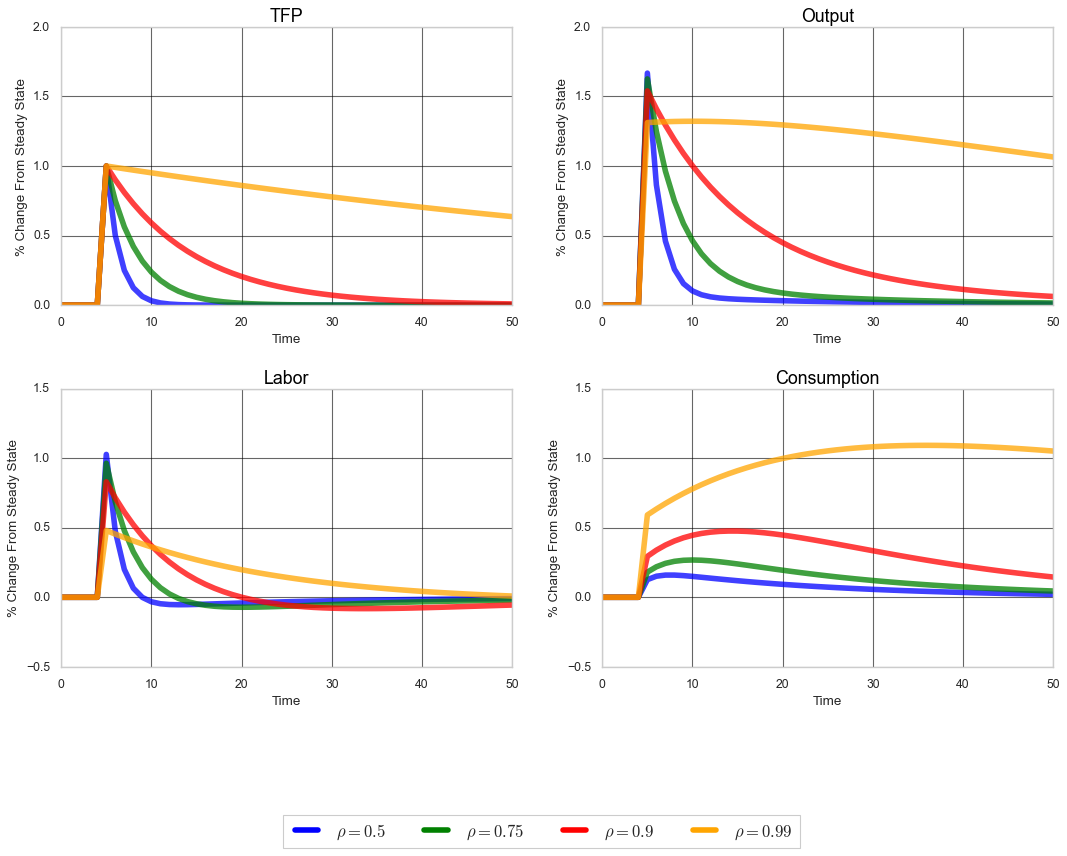

In [203]:
#Set theme with seaborn
sns.set_theme(style="whitegrid")

#Create a figure and axes for the plot
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
fig.subplots_adjust(hspace=0.3)

#Turn off axis
fig.add_subplot(111).axis('off')

#Store rho values in a list
rho_values = [0.5, 0.75, 0.9, 0.99]
#Store guess values for computing steady state
guess = pd.Series({'a': 1, 'k': 4, 'y': 1, 'c': 1, 'l': 0.5, 'i': 1})
#Store titles for each Graph
titles = ['TFP', 'Output', 'Labor', 'Consumption']
#Store y limits for each graph
y_limits = [(0, 2), (0, 2), (-0.5, 1.5), (-0.5, 1.5)]
#Store colors in a list for each line
colors = ['blue', 'green', 'red', 'orange']

#Initiate a for loop to go through each rho value and plot
for i, rho in enumerate(rho_values):
    #Update the RBC model initiation to the new rho value
    rbc_model.parameters['rho'] = rho
    #Compute the guess using the RBC model
    rbc_model.compute_ss(guess)
    #Approximate and solve
    rbc_model.approximate_and_solve()
    #Compute the impulse responses to a 1% shock to TFP
    rbc_model.impulse(T=51, t0=5, shocks=[0.01])
    
    #Go through plots with a for loop
    for j, (ax, title, y_lim, ir_key) in enumerate(zip(axs.flatten(), titles, y_limits, ['a', 'y', 'l', 'c'])):
        # Plot without any label for individual legends
        sns.lineplot(x=range(51), y=rbc_model.irs['e_a'][ir_key] * 100, lw=5, alpha=0.75, ax=ax, color=colors[i])  # No label for individual graphs
        #Title size 
        ax.set_title(title, fontsize=16, color='black')
        #Y limit
        ax.set_ylim(y_lim)
        #Set x axis label and font
        ax.set_xlabel('Time', fontsize=12)
        #Set y axis label and font
        ax.set_ylabel('% Change From Steady State', fontsize=12)
        #Line style 
        ax.grid(True, linestyle='-', alpha=0.6, color='black')
    
#Create a legend for the graph to be at the bottom in the center
fig.legend([plt.Line2D([0], [0], color=color, lw=5) for color in colors], 
           [f'$\\rho={rho}$' for rho in rho_values], loc='upper center', 
           bbox_to_anchor=(0.5, -0.075), ncol=4, fontsize=15)


fig.patch.set_facecolor('white')

plt.show()


## Results, Analysis, and Conclusions

In our model we utilize a differing parameter value to change the lasting time of the prior term's total factor productivity value. Thus, when we see a shock of 1% is implemented to TFP, we notice that the lines decay at different rates, with the $\rho = .99$ lasting the longest, as expected.

Thus, we take a look at the graph for the output impulse responses. What is interesting is that we see a smaller output response in the world with a larger prior term TFP value. This is because households are aware that the TFP will last longer over time, and thus there isn't as much of a desire to commit labor in the current session due to a knowledge of a longer lasting future TFP. Because the marginal product of labor increases as a result of the TFP shock, we see that labor takes a spike in all of the different lasting coefficients for $\rho$. However, we note that the labor does not spike nearly as much in the world where there is a lower $\rho$ value. This is because the households are aware that the increase in TFP will last longer, and thus will choose to have a more steady labor supply compared to a large spike that suddenly vanishes.

We can see that the lower the $\rho$ value, the larger the immediate spike in labor in response to TFP. This is understandable, as households are looking to cash in on the spike in marginal product of labor which makes labor more enticing, but it decays incredibly quickly. The reason for the faster decay is due to the fact that the lower value for $\rho$ means that the shock to TFP goes away much faster, meaning that the increased desire for labor of households will not still be as high because the increase in value drops off.

When we look at consumption, we see that the higher $\rho$ value group has the highest spike compared to the others, but it continues to grow over time. Keep in mind that consumption should be kept smooth over time, as households are bound by the Euler equation which tells us that future consumption is equal to some ratio of present consumption. Thus, we see a much more stable decaying of the consumption increase compared to labor and output, which decay at a much, much faster rate. This is why the decay from consumption is far slower, and why the increase continues to grow over time for all four lines at differing lengths of time. 